In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## Standard Error


Recall that the standard error is given by:

$$
SE = \frac{\sigma}{\sqrt{N}}
$$

In [2]:
def trading_system(exchange: str) -> float:
    if exchange == "ASDAQ":
        execution_cost = 12.0
    elif exchange == "BYSE":
        execution_cost = 10.0
    else:
        raise ValueError("Exchange Not supported")
    execution_cost += np.random.normal()
    return execution_cost

In [3]:
def aggregate_measurement_with_se(exchange: str, num_individual_measurements: int):
    individual_measurements = np.array(
        [trading_system(exchange) for _ in range(num_individual_measurements)]
    )
    aggregate_measurement = individual_measurements.mean()
    sd_1                  = individual_measurements.std()
    se = sd_1 / np.sqrt(num_individual_measurements)
    return aggregate_measurement, se

In [4]:
np.random.seed(17)
print(aggregate_measurement_with_se("ASDAQ", 300))
print(aggregate_measurement_with_se("BYSE",  300))

(np.float64(12.000257642551059), np.float64(0.060254756364981225))
(np.float64(10.051095649188758), np.float64(0.05714189794415452))


### Note:

We can look at these numbers from a single experiment, with no histogram available and claim 
that BYSE is very likely the better choice by this reasoning:

BYSE's expectation might be higher than the aggregate measurement:
Say 10.05 + 0.057 = 10.107

Similarly ASDAQ's expectation might be lower than the aggregate by:
12.00 - 0.060 = 11.94

Even if both of these are true we still have that BYSE is cheaper.


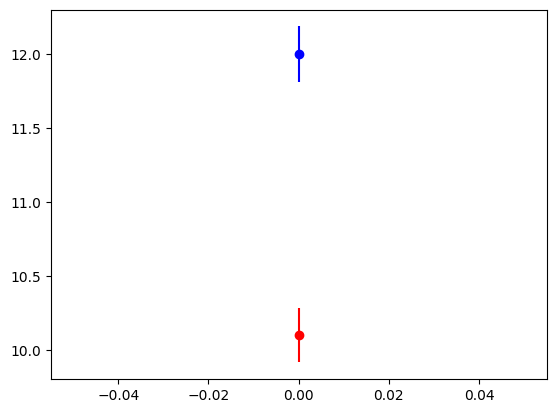

In [29]:
np.random.seed(17)
asdaq_avg, asdaq_se = aggregate_measurement_with_se("ASDAQ", 30)
plt.scatter(0, asdaq_avg, color = "blue")
plt.vlines(0, ymin=asdaq_avg - asdaq_se, ymax=asdaq_avg + asdaq_se, color = "blue")

byse_avg,  byse_se  = aggregate_measurement_with_se("BYSE",  30)
plt.scatter(0,  byse_avg, color = "red")
plt.vlines(0, ymin=byse_avg - byse_se, ymax=byse_avg + byse_se, color = "red")

plt.show()

## Back to Standard Error

We have:

$$
SE
= 
\frac{\sigma}{\sqrt{N}}
$$

We should be kosher and know where $\sqrt{N}$ comes from. Let's recall the following:

1. $Var(X) = Std(X)$
2. $Var(X + y) = Var(X) + Var(Y)$ (assuming $X,Y \sim i.i.d$ from their distribution)
3. For any $a \neq 0$, we have $Var(\frac{X}{a}) = \frac{Var(X)}{a^2}$

We take $N$ measurements (i.i.d) to get our aggregate measurement:

$$
agg
=
\frac{x_1 + \dots + x_N}{N}
$$

The variance fo the aggregate measurement is, by 1. and 3. given by

$$
Var(agg)
=
\frac{Var(x_1) + \dots + Var(X_N)}{N^2}
$$

All the individual measurements are taken from the same distribution, so they all 
have the same standard deviation, call it $\sigma = Std(X)$. So $Var(x_i) = \sigma^2$.
And now we have:

$$
Var(agg)
=
\frac{\sigma^2 + \dots + \sigma^2}{N^2}
= 
\frac{N \sigma^2}{N^2}
$$

Therefore:

$$
SE 
=
\sqrt{Var(agg)}
=
\frac{\sigma}{\sqrt{N}}
$$

## Reducing Number of Measurements

It takes time and money to collect measurements. So it's in our interest to reduce the number of measurements 
while still being able to correctly make inferences about the data collected.

### Trade-Off:

Decreasing the number of measurements increases the SE of the aggregate measure.

To remedy this, we think about the problem backwards. Recall that we are trying to prove the following:

        The A/B test for making our decision of A over B or B over A is probably not wrong.

The keyword being `probably`!

To make this a little easier to understand, let's define `delta`, the difference between the aggregate 
measurement of BYSE and ASDAQ.

In [6]:
np.random.seed(17)
num_individual_measurements = 10
agg_asdaq, se_asdaq = aggregate_measurement_with_se("ASDAQ", num_individual_measurements)
agg_byse, se_byse= aggregate_measurement_with_se("BYSE", num_individual_measurements)

delta = agg_byse - agg_asdaq
se_delta = np.sqrt(se_byse**2 + se_asdaq**2)
print(delta)
print(se_delta)

-2.2721337833056996
0.5065929285007608


Notice that if `delta` were positive, this would imply ASDAQ is cheaper than BYSE.

On the other hand a negative delta suggests that BYSE is cheaper.

1. From the hypothesis frame work we state that there is no diffence between expected cost of
A and B. In other words the delta is $0$. 

2. If our measurment of delta is so far from $0$ that there's less than a $5\%$ chance the
statement in step $1$ is right, then we act as if step $1$ is wrong and the true delta is 
not $0$.

So if our delta is significantly lower than $0$ we will start sending trades to BYSE.
We don't know for certain if this is right, but we're willing to take this bet with 
at most a  $5\%$ chance of being wrong that BYSE is better.


For convenience, it's easier to work with z = delta/se_delta, the z-score which standardizes
the distribution of the deltas to a gaussian $N(0, 1)$ distribution.




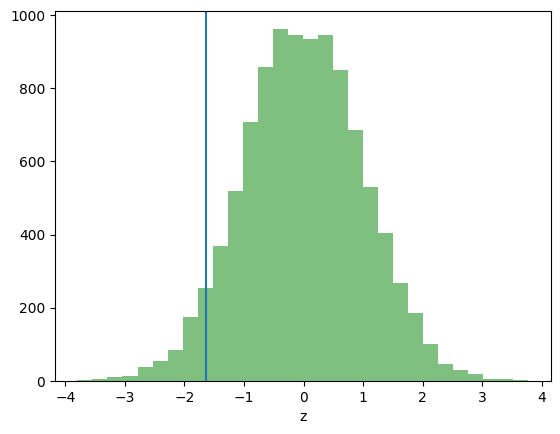

In [7]:
np.random.seed(17)
z = np.random.normal(size=(10000,))
plt.hist(z, 30, color = 'green', alpha = 0.5)
plt.axvline(-1.64)
plt.xlabel("z")
plt.show()

The figure above is our standard gaussian distribution. 

There is a $5\%$ chance that our z score (coming from our normalized delta) will fall to the left of the line.

If it does, you should bet that your assumption in step 1. is wrong. We should instead bet that the 
z is truly less than zero, which means that the expectation of delta is less than zero.

That implies that BYSE is cheaper than ASDAQ. When z is to the left of the vertical line, we say that the aggregate 
is statistically significant.

### Remember:

If $z <-1.64$, then we act as if BYSE is cheaper than ASDAQ and start trading there.

Otherwise we act as if BYSE is no better than ASDAQ and continue trading on ASDAQ.


## False Positives:

When your bet is wrong: when z falls to the left of the line, but the expectation is non-negative, this is called 
a `false positive`.

By our design, false positives occur $5\%$ of the time. 


### Being Practical:

How big of a differnce in the execution costs do we actually care about?

If BYSE is cheaper on average by 1, is it really worth switching over? What about $0.01$? Is $0.001$ too small?

Afterall, switching over can introduce us to new risk that our old model was not exposed to.

So another term to consider is `practical significance`, denoted prac_sig.

Suppose prac_sig $=1.0$. Then even if we show a statistically significant measurement, if it turns out that 
$-0.1 < delta < 0.0$ (i.e. $\text{delta} \geq -\text{prac\_sig}$ ), we should still act as if $\text{delta} = 0$.

## Finally Back to the Number of Measurements


In [ ]:
# Recall that z = delta/ se_delta and that 
# se_delta = np.sqrt(se_byse**2 + se_asdaq**2)
# In general we have:
# se = sd_1 / np.sqrt(num_ind) where sd_1 is the standard deviation of an individual measurement

# Similarly we can compute sd_1 for delta, denoted sd_1_delta
np.random.seed(17)
num_ind = 100
sd_1_asdaq = np.array([trading_system("ASDAQ") for _ in range(100)]).std()
sd_1_byse  = np.array([trading_system("BYSE") for _ in range(100)]).std() #sd_1_asdaq # for simplicity
sd_1_delta = np.sqrt(sd_1_asdaq**2 + sd_1_byse**2)
print(sd_1_delta)


# Thus z is given by:
z = np.sqrt(num_ind) * delta / sd_1_delta
print(z)

# But more importantly we can instead say we want our False positive rate to be 5% which corresponds to z < - 1.64
# And now we solve for num_ind instead

# num_ind > (1.64  * (sd_1_delta / delta)) ** 2

num_ind =  (1.64  * sd_1_delta / delta) ** 2
print(np.ceil(num_ind))

# So if we make num_ind tades on BYSE and num_ind trads on BYSE, then we compute the two averages 
# agg_byse and agg_asdaq and compute delta = agg_byse - agg_asdaaq
# This means we're making 2 * num_ind trades in total.
print(2*np.ceil(num_ind))


1.4684646529399712
-15.47285308336653
2.0
4.0


There is still one problem about this design!

We don't know delta or sd_1_delta.

They are summary statistics of indicidual measurements that you have yet to take.

The good news is that you can find good design-time subsitutes for these numbers.

`Firstly`: in place of delta we can subsistute our practical significance level `prac_sig`.
By doing this, you are saying that you want to be able to measure to make statistically 
significant delta values that are at leaset as large (in magnitue) as `prac_sig`.

The value of prac_sig is based on business considerations, we may specify it at design time 
without taking any measurements.

For our example we require a difference of prac_sig = 1.0 inorder to merit switching from ASDAQ to BYSE.

`Secondly`: We can estimate sd_1_delta in one of two ways:

1. Take the standard deviation of existing measurements from logged/historical data.
Say we've been trading on ASDAQ before we considered moving to BYSE, then we can compute sd_1_asdaq and 
guess that sd_1_byse = sd_1_asdaq

    You can get away with this if the business metric variations don't change much from version A to version B.

    This is likelybecause you are changing only one isolated aspect of the syßtem and the business metric variation 
    are due to all aspects of the system (plus variants in the market).

    We then approximate ```sd_1_delta = np.sqrt(sd_1_asdaq**2 + sd_1_byse**2) = np.sqrt(2 * sd_1_asdaq**2)```

2. Alternatively, in cases where you suspect that your change from version A to version B is dramatic enough 
to maek the variations (the sd_1's) different, you can run a small-scale measurement just to measuer sd_1. 

    This is called a pilot study.

    You could estimate sd_1_asdaq and sd_1_byse directly from logged costs collected during a pilot study, then 
    compute sd_1 from these estimates.


For simplicity we go with the first option.

In [9]:
np.random.seed(17)
num_ind = 100
sd_1_asdaq = np.array([trading_system("ASDAQ") for _ in range(100)]).std() # This is historically logged data we already have
sd_1_byse  = sd_1_asdaq # using the trick we discussed
sd_1_delta = np.sqrt(sd_1_asdaq**2 + sd_1_byse**2)
print(sd_1_delta)

def ab_test_design(sd_1_delta: float, prac_sig: float = 1.0): # we default our practical significance to 1.0
    num_individual_measurements = (1.64 * sd_1_delta / prac_sig) ** 2 # ensure z < -1.64 when delta < -1 * prac_sig
    return np.ceil(num_individual_measurements) # round up to nearest integer

print(ab_test_design(sd_1_delta))

1.5850244424014406
7.0


So if we take 7 individual measurements, we'll have a $5\%$ chance of a false positive of incorrectly 
acting as if BYSE is better than ASDAQ.

## False Discovery Rates (FDR)

Okay first thing's first, let's de-brief on hypothesis testing:

### Hypothesis Testing

We have $72$ lukemia patients

1. $47$ with ALL (acute Lymphobastic leukemia)
2. $25$ with AML (acute myeloid leukemia, a worse prognosis)

Each disease had a genetic activity measured for a panel of 7,128 genes.

Let's download the data and construct a histogram comparing the genetic activities in 
the two groups for gene 136


In [10]:
data = pd.read_csv("https://hastie.su.domains/CASI_files/DATA/leukemia_big.csv")

In [11]:
display(data)

,ALL,ALL.1,ALL.2,ALL.3,ALL.4,ALL.5,ALL.6,ALL.7,ALL.8,ALL.9,...,AML.15,AML.16,AML.17,AML.18,AML.19,AML.20,AML.21,AML.22,AML.23,AML.24
0,-1.533622,-0.867610,-0.433172,-1.671903,-1.187689,-1.127234,-1.045409,-0.106917,-1.198796,-1.190899,...,-0.436650,-1.274708,-0.681458,-0.876610,-0.624022,-0.431628,-1.435259,-0.671954,-1.013161,-0.969482
1,-1.235673,-1.275501,-1.184492,-1.596424,-1.335256,-1.113730,-0.800880,-0.745177,-0.849312,-1.190899,...,-0.915483,-1.354363,-0.653559,-1.096250,-1.066594,-1.335256,-1.204586,-0.751457,-0.889592,-1.080988
2,-0.333983,0.375927,-0.459196,-1.422571,-0.797493,-1.362768,-0.671954,-1.175674,0.320813,0.646610,...,-0.736156,-0.022153,-0.037455,-0.567335,-1.100749,-0.552938,-0.948874,-0.231657,-0.742163,-0.779500
3,0.488702,0.444011,0.436264,0.193353,0.235632,-0.360312,0.184941,0.425653,0.333983,0.235270,...,0.083781,0.356562,0.416241,0.533986,0.227505,0.416816,0.408202,0.326556,0.361813,0.298864
4,-1.300893,-1.229660,-1.325882,-1.818329,-1.311206,-1.513975,-1.651624,-1.339555,-0.593132,0.133302,...,-1.547444,-1.264475,-1.512318,-1.469583,-1.283472,-0.977672,-1.090178,-1.545120,-1.174272,-1.443183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,1.295992,-0.218494,1.132893,1.113077,0.719203,1.490610,0.483163,1.433292,0.737309,0.633018,...,1.097533,1.154533,1.401608,1.442685,1.097212,0.616776,0.904313,0.861478,1.183783,1.500833
7124,0.733853,0.378380,0.475669,0.148928,0.419502,1.000031,0.258833,-0.498831,-0.657700,-0.373663,...,0.496841,0.390495,0.379136,0.833781,0.298680,-0.161740,0.254654,0.558272,0.290234,0.159425
7125,-0.301622,-0.663166,-0.530138,-0.625945,-0.487514,-0.172972,-0.052590,-0.512817,-1.005845,-1.245923,...,-0.340496,-0.419886,-0.502218,-0.455682,-0.480793,-0.518640,-0.603435,-0.637751,-0.395623,-0.584142
7126,0.133657,-0.663166,1.566946,0.871972,0.358999,0.080430,0.029891,1.553879,-0.144841,0.129578,...,1.586444,0.216334,1.708574,1.710849,0.844280,1.771676,0.503216,0.079548,0.311388,0.793874


In [12]:
data.shape

(7128, 72)

In [13]:
index = 135
ALL = []
AML = []
for key in data.iloc[index].keys():
    if "ALL" in key and key != "ALL":
        ALL.append(data.iloc[index][key])
    else:
        if key != "AML":
            AML.append(data.iloc[index][key])
ALL = np.array(ALL)
ALL_mean = ALL.mean()
AML = np.array(AML)
AML_mean = AML.mean()


In [14]:
print(ALL_mean)
print(AML_mean)

0.7488660087608695
0.9560340174399999


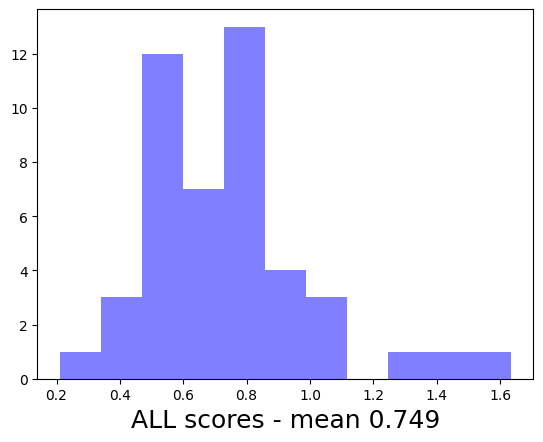

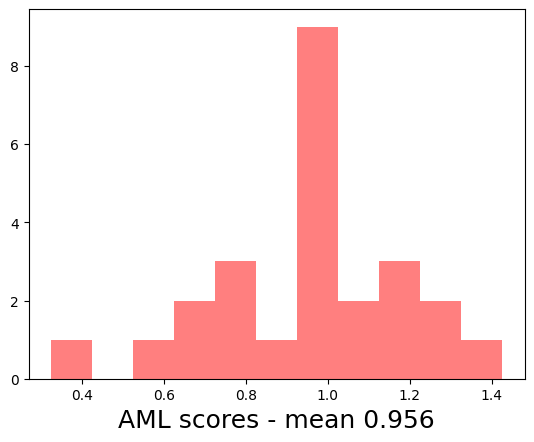

In [15]:
plt.hist(ALL, color = "blue", alpha=0.5, bins=11)
plt.xlabel(f"ALL scores - mean {ALL_mean:.3f}", size=18)
plt.show()
plt.hist(AML, color = "red", alpha=0.5, bins=11)
plt.xlabel(f"AML scores - mean {AML_mean:.3f}", size=18)
plt.show()

It appears that the AML group shows greater activity for gene 136 on average compared to 
the ALL group. Let's compute the t and p values.

In [17]:
t_val, p_val = stats.ttest_ind(AML, ALL)

In [18]:
print(t_val, p_val)

3.1470195346961534 0.0024356001809915707


We see a p value far below $0.05$ which is suggestive that perhaps there is a difference betwen ALL and AML on gene 136.
Could it be that gene 136 is an indicator of the presence of AML?

Is there anything wrong with our analysis?

## Too Many candidates:

Firstly there are $7128$ genes. Don't you think by chance we'd just naturally get some $t$ values exceeding $3$ when
performing a two-sample t-test?

To see the chances of this, let's empirically compute the distribution of t-values:

In [19]:
cols_all = [col for col in data.columns if col.startswith("ALL")]
cols_aml = [col for col in data.columns if col.startswith("AML")]

In [21]:
t_values = []
for _, row in data.iterrows():
    values_all = row[cols_all].values
    values_aml = row[cols_aml].values
    t, _ = stats.ttest_ind(values_aml, values_all)
    t_values.append(t)

In [ ]:
dist_x = np.arange(-10, 10, 0.1)
dist_t = stats.t.pdf(dist_x, df=70)

(-30.0, 720.0)

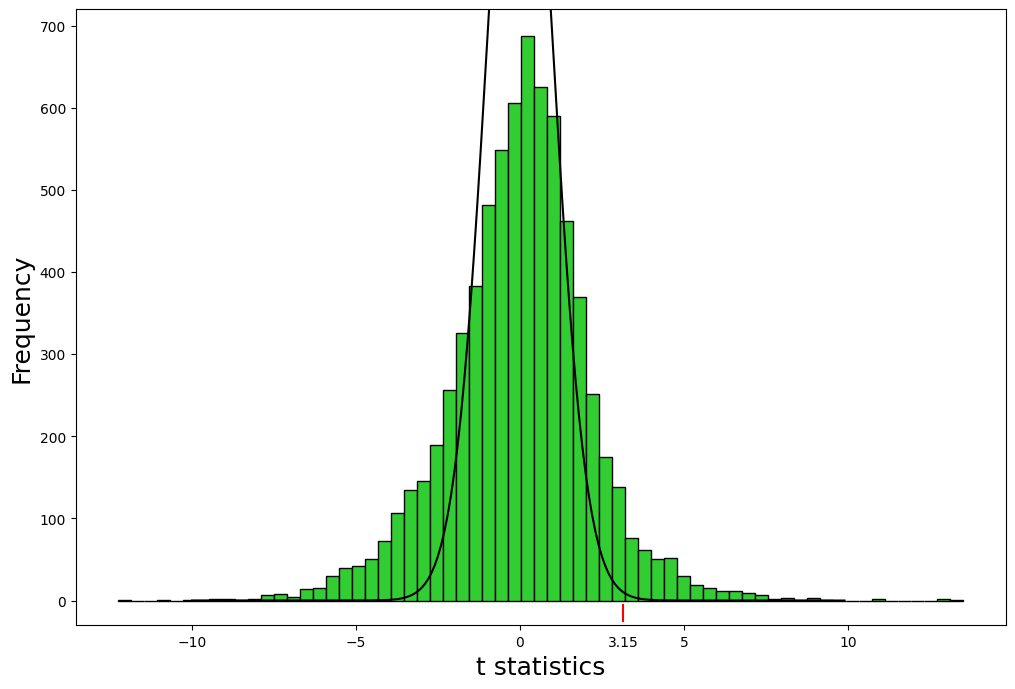

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))

hist_info = ax.hist(t_values, bins=65, edgecolor="k", facecolor="limegreen")
bin_y, bin_x = hist_info[0], hist_info[1]
hist_area = ((bin_x[1:] - bin_x[:-1]) * bin_y).sum()

ax.plot(dist_x, dist_t * hist_area, c="k")

ax.set_xticks([t_val], minor=True)
ax.set_xticklabels([np.round(t_val, 2)], minor=True)
ax.tick_params(axis='both', which='minor', length=4, color="white")

ax.plot([t_val, t_val], [-5, -25], c="r")

ax.set_xlabel("t statistics", size=18)
ax.set_ylabel("Frequency", size=18)
ax.set_ylim(-30, 720)

This plot reveals two complications!

1. There are $400$ other genes that have a t value exceeding 3.
2. The theoretical t-distribution in black is far more limiting than what we are seeing empirically.


This is a compilication of having many many candidates that we can look at, thus increasing our chances of a `False Discovery`.
Later we will learn that we would actually need a t-value of about 6.16 to actually show if there is any statistical power in 
gene indicating AML.